# **Lorem ipsum dolor sit amet, consectetur adipiscing elit.**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus at urna lacus. Proin lacinia consectetur lobortis. Integer id lacus elementum, luctus augue ac, interdum nunc. Nam tempus, nibh a pellentesque scelerisque, velit urna maximus magna, et hendrerit ipsum sem a enim. Sed pretium vehicula lectus, in vestibulum turpis tristique at. Nam vel elementum ipsum. Suspendisse aliquet libero enim, suscipit posuere libero gravida a. Maecenas commodo, neque vel iaculis auctor, dolor odio rhoncus mi, sit amet sagittis quam turpis sit amet augue. Phasellus quis leo vitae ipsum fermentum facilisis. Suspendisse non est mollis, aliquam tortor at, maximus lacus. Mauris pellentesque vestibulum imperdiet. Nullam dignissim malesuada ipsum, et pretium lorem. Morbi risus libero, consectetur porta vulputate id, hendrerit hendrerit nulla. Duis ut tellus nec erat ullamcorper faucibus. Sed dapibus neque ut metus consectetur laoreet. Donec tincidunt sapien at neque scelerisque, vel mollis arcu fermentum.

**Authors:**
- [Daniel Valdez](https://github.com/Danval-003)
- [Emilio Solano](https://github.com/emiliosolanoo21)
- [Adrian Flores](https://github.com/adrianRFlores)
- [Andrea Ramírez](https://github.com/Andrea-gt)

***

## **(1) Import Libraries** ⬇️

In [1]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import subprocess
from PIL import Image

# Set the maximum allowable pixels to a higher number.
Image.MAX_IMAGE_PIXELS = None

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

## **(2) Data Upload** 📄

In [2]:
# Note:
# -----
# For this specific task, we are only using the training data (`train.csv`) throughout most of our analysis.
# The test dataset (`test.csv`) will not be used until the very end when making final predictions.
# We will train, validate, and tune your model using the training data only.
#
# The reason the test data is only used at the very end is to prevent any bias during model training and evaluation.
# We want the test data to remain completely unseen until after we've finalized our model so that it can serve
# as a true evaluation of our model's performance.
# ---------------------------------------------

df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')  # Load the training data
df.head()  # Display the first 5 rows of the DataFrame for a quick inspection of the data

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


## **(3) Exploratory Analysis** 🔎

### **(1) Descripción de los Datos**

In [3]:
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 754 registers and 5 columns.


**Observaciones 💡 -->**
> - El conjunto de datos contiene más de mil imágenes de patología digital de alta resolución de diapositivas completas. Cada diapositiva representa un coágulo de sangre de un paciente que sufrió de un accidente cerebrovascular isquémico agudo. 

> - En el conjunto `train.csv`, con el que se trabajará por el momento, se cuenta con 754 registros y 5 columnas, lo que indica que tiene una dimensión relativamente pequeña. Cada uno de los 754 registros representa una anotación única con relación a una de las imágenes dentro del directorio `train/`.

**Fuente:** [Página oficial de Kaggle](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data)

In [4]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


- `image_id`: Un identificador único para la instancia, con el formato {patient_id}_{image_num}. Corresponde a la imagen {image_id}.tif.
- `center_id`: Identifica el centro médico donde se obtuvo la diapositiva.
- `patient_id`: Identifica al paciente del que se obtuvo la diapositiva.
- `image_num`: Enumera las imágenes de coágulos obtenidas del mismo paciente.
- `label`: La etiología del coágulo, que puede ser CE (embolia cardioembólica) o LAA (ataque isquémico). Este campo es el objetivo de clasificación.

<div class="alert alert-block alert-info">
<b>Nota importante:</b> Las diapositivas que conforman los conjuntos de entrenamiento y prueba representan coágulos con una etiología (es decir, origen) que se conoce como CE (cardioembólica) o LAA (aterosclerosis de grandes arterias).
</div>

**Fuente:** [Página oficial de Kaggle](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data)

### **(2) Clasificación de Variables**

| Nombre      | Descripción                                                       | Tipo                          |
|-------------|-------------------------------------------------------------------|-------------------------------|
| image_id    | Identificador único de la imagen.                                 | Cualitativa (Nominal)         |
| center_id   | Identificador del centro médico donde se tomó la diapositiva.     | Cualitativa (Nominal)         |
| patient_id  | Identificación del paciente de la diapositiva.                    | Cualitativa (Nominal)         |
| image_num   | Número que indica la secuencia de imágenes de un mismo paciente.  | Cuantitativa (Discreta)       |
| label       | Clasificación del coágulo: CE (cardioembólica) o LAA (aterosclerosis). | Cualitativa (Nominal)    |


**Observaciones 💡**
> - En nuestro conjunto de datos, la mayoría de las variables son de tipo **cualitativo nominal**.

> - Por otro lado, solo una variable es de tipo **cuantitativo discreto**, que corresponde al número de imagen.

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Previsualización de Imágenes**

In [5]:
# Assuming your DataFrame is named df
base_path = "../input/mayo-clinic-strip-ai/train/"

# Add the full path to the df
df['image_path'] = base_path + df['image_id'] + '.tif'

# Preview the DataFrame to ensure the new column is added correctly
df.head()

,image_id,center_id,patient_id,image_num,label,image_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif


**Observaciones 💡**

> - Una de las principales técnicas de preprocesamiento será **incluir el path o la dirección de cada imagen** dentro del DataFrame. Esto permitirá acceder a las imágenes de manera más sencilla, ya que, como se ha mencionado anteriormente, todas las imágenes se encuentran almacenadas en el directorio `train`.

In [6]:
def plot_images(df, num_images=5):
    # Select first n images
    sample_df = df.head(num_images)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    # Flatten axes to make it easier to iterate
    axes = axes.flatten()
    
    for i, (img_path, label) in enumerate(zip(sample_df['image_path'], sample_df['label'])):
        img = Image.open(img_path)
        img.thumbnail((300,300), Image.Resampling.LANCZOS)
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

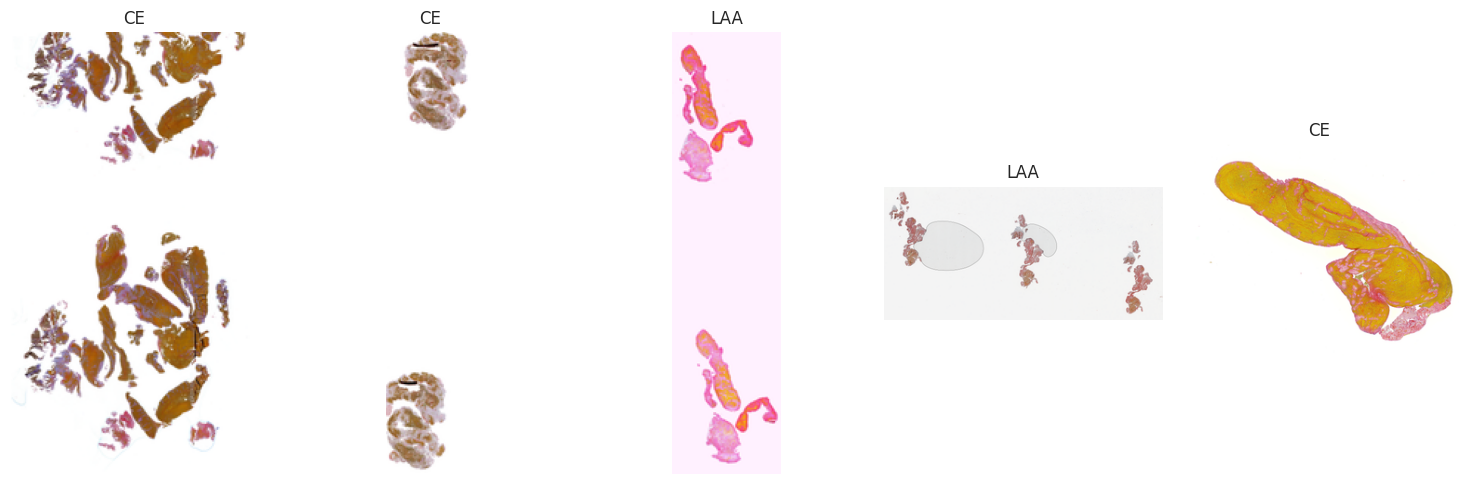

In [7]:
# Show 5 images
plot_images(df)

**Observaciones 💡**

> - Una de las primeras observaciones clave es la gran variabilidad en los tamaños de las imágenes presentes en el conjunto de datos. Estas imágenes muestran diferentes valores de relación de aspecto, lo cual puede presentar desafíos al momento de alimentar estos datos en un modelo predictivo. 

> - También hemos detectado una variación considerable en las características cromáticas de las imágenes. Por ejemplo, algunas de ellas presentan fondos blancos, mientras que otras tienen fondos grises. Esto puede introducir ruido en el modelo si no se trata adecuadamente, ya que los modelos de visión por computadora son sensibles a las variaciones en las condiciones de iluminación y color de las imágenes.

> - Adicionalmente, las imágenes presentan una mezcla de elementos que pueden afectar la precisión del modelo. Algunos coágulos están claramente definidos, mientras que otros están parcialmente oscurecidos o presentan sombras y brillos que pueden confundir al modelo.

Todas extas observaciones reflejan los primeros desafíos que enfrentaremos en el preprocesamiento de imágenes, un paso que se realizará más adelante.

#### **(2) Distribución de Labels**

In [8]:
def label_distribution(df, name='Training Dataframe'):
  label_counts = df['label'].value_counts().sort_index()
  total_counts = label_counts.sum()
    
  # Calculate percentages
  label_percentages = (label_counts / total_counts) * 100
    
  # Plot counts
  plt.plot(1, 2, 1)
  label_counts.plot(kind='bar', color=[palette[0], palette[6]])
  plt.title(f'{name}: Label Counts')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.tight_layout()
  plt.show()

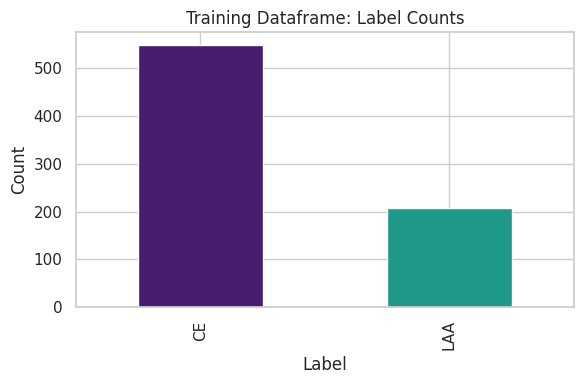

In [9]:
label_distribution(df)

**Observaciones 💡**

> - Nuestro conjunto de datos presenta un **fuerte desbalance**, ya que se cuenta con aproximadamente 550 imágenes de coágulos de **etiología cardioembólica (CE)**, lo que representa más del 70.0% del total de muestras.
  
> - En contraste, solo se disponen de 200 imágenes de coágulos de **etiología aterosclerótica de grandes arterias (LAA)**, lo que corresponde a **menos del 30.0%** del conjunto de datos.

> - Este desequilibrio entre las clases puede tener un impacto negativo en el rendimiento del modelo predictivo, ya que probablemente este se incline a **predecir mayormente la clase CE** debido a la falta de representatividad de la clase LAA. Un modelo sesgado de esta manera podría no capturar adecuadamente las características distintivas de los coágulos LAA, reduciendo su capacidad para hacer predicciones precisas.

> - Para mitigar este problema, se tendrá que explorar técnicas como **submuestreo de la clase mayoritaria**, o el uso de algoritmos tales como **data augmentation**. Aunque esto forma parte de los siguientes pasos a tomar.

#### **(3) Distribución de Tamaños de Imagen**